In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from typing import Tuple, List, Dict
from sklearn.model_selection import KFold, train_test_split
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from IPython import display
import warnings
warnings.filterwarnings('ignore')

plt.style.use('_mpl-gallery')

def normal(mean, std, histmax=False, color="black", ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = norm.pdf(x, mean, std)
    if histmax:
        p = p*histmax/max(p)
    # print(x.max(), x.min(), p.max(), p.min())
    ax.plot(x, p, color, linewidth=2, **kwargs)

# Kaggle比赛：加利福利亚房价

[比赛链接](https://www.kaggle.com/competitions/california-house-prices/data)

In [7]:
DATA_PATH="./data"

def read_data_from_csv():
    return pd.read_csv(os.path.join(DATA_PATH, "train.csv")), pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

In [3]:
train_data, test_data = read_data_from_csv()
train_data.drop("Id", axis=1, inplace=True)
test_data.drop("Id", axis=1, inplace=True)
n_train, n_test = train_data.shape[0], test_data.shape[0]
train_data.shape, test_data.shape

((47439, 40), (31626, 39))

## 特征工程

In [4]:
train_data.columns

Index(['Address', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating',
       'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip', 'State'],
      dtype='object')

- 数值类型

|特征|含义|影响|备注|
|:-:|:-|:-:|:-|
|Lot|占地面积|高||
|Total interior livable area|室内居住总面积|高||
|Total spaces|总面积|高||
|Garage spaces|车库面积|中||
|Elementary School Score</br>Middle School Score</br>High School Score|小学评分</br>初中评分</br>高中评分|中|1-10区间内|
|Elementary School Distance</br>Middle School Distance</br>High School Distance|小学距离</br>初中距离</br>高中距离|中||
|Tax assessed value|纳税估值|高||
|Annual tax amount|每年纳税|高||
|Listed Price|挂牌价格|高||
|Last Sold Price|上次售价|高||


- 类别型数据

|特征|含义|影响|备注|
|:-:|:-|:-:|:-|
|Year build|建造年份|高||
|Heating|供暖|中|这是一个list类型的特征，总共包含138种元素|
|Cooling|空调|中|同上|
|Parking|停车场|高|同上|
|Bedrooms|卧室数|中|该特征既包含str也包含数字，str描述卧室特征|
|Bathrooms|卫生间数|中||
|Full Bathrooms|可以洗澡的卫生间数|中||
|Region|所在区域|高|类别特别多，950中|
|Elementary School|周边小学|低|类别很多，千级别|
|Middle School|周边初中|低|类别较多，500|
|High School|周边高中|低|类别较多|500+|
|Flooring|地板|低|同Heating，100左右|
|Heating features|供暖特征|低|同Heating，100|
|Cooling features|冷气特征|低|同Heating，100|
|Appliances included|电器|低|同Heating，100|
|Laundry features|洗衣房特征|低|同Heating，100|
|Parking features|车库特征|低|同Heating，100|
|Listed On|挂牌时间|中|天级别|
|Last Sold On|上次卖出时间|中|天级别|
|City|城市|高||
|State|州|低||
|Zip|邮编|低|邮编和**Address**类似，而相比较**Address**，邮编给买家并不会带来更直观的信息|

- 其他

|特征|含义|影响|备注|
|:-:|:-|:-:|:-|
|Address|地址|高||
|Summary|简介|高|可能存在和其他特征重复的信息或者会有额外的信息|


### 特征分析

#### 数值类型的特征

总共包含14个数字类型的特征

In [5]:
numeric_columns = train_data.dtypes[train_data.dtypes != 'object'].index
numeric_columns = numeric_columns.drop(['Year built', 'Bathrooms', 'Full bathrooms', 'Zip'])
numeric_columns

Index(['Sold Price', 'Lot', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Elementary School Score',
       'Elementary School Distance', 'Middle School Score',
       'Middle School Distance', 'High School Score', 'High School Distance',
       'Tax assessed value', 'Annual tax amount', 'Listed Price',
       'Last Sold Price'],
      dtype='object')

通过热力图，可以看到各个特征之间的相关度。

和**Sold Price**非常相关的包含四个特征，前面感觉**面积**类的特征应该和**Sold Price**很相关，比如**Lot**，但是通过热力图看到他们的关系并不大。

1. **Annuam Tax Amount**
2. **Tax assessed value**
3. **Last Sold Price**
4. **Listed Price**

还有一个很有趣的现象，就是这四个特征的相关度也很大，可能存在[多重共线性](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)。

第二点学校距离，**Elementary School Distance**、**Middle School Distance**、**High School Distance**三个特征之间相关度也很大，这表明学校都规划在一个区域。

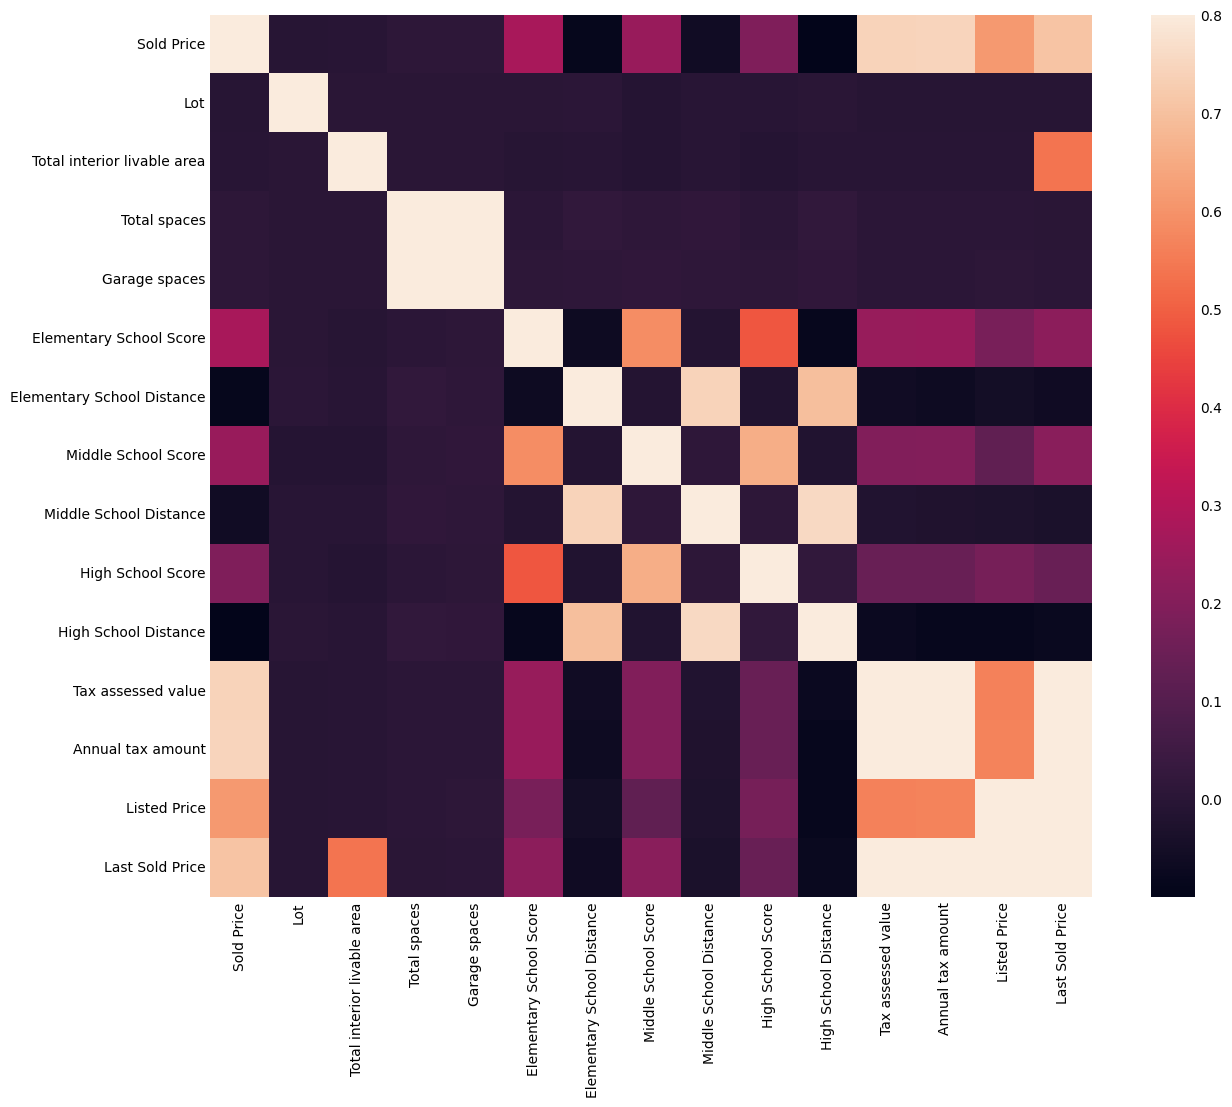

In [6]:
corrmat = train_data[numeric_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

和**Sold Price**具有很强烈关系的特征包含四个，绘制散点图进一步观察下。

In [7]:
k = 5
cols = corrmat.nlargest(k, 'Sold Price').index
cols

Index(['Sold Price', 'Annual tax amount', 'Tax assessed value',
       'Last Sold Price', 'Listed Price'],
      dtype='object')

哦豁，首先看第一行，表明这四个特征和**Sold Price**呈线性关系。

接下来看第二行的第三张图，也就是**Tax assessed Value**和**Annual tax amount**，线性关系过于明显，并且这两个特征对**Sold Price**的影响几乎一样。

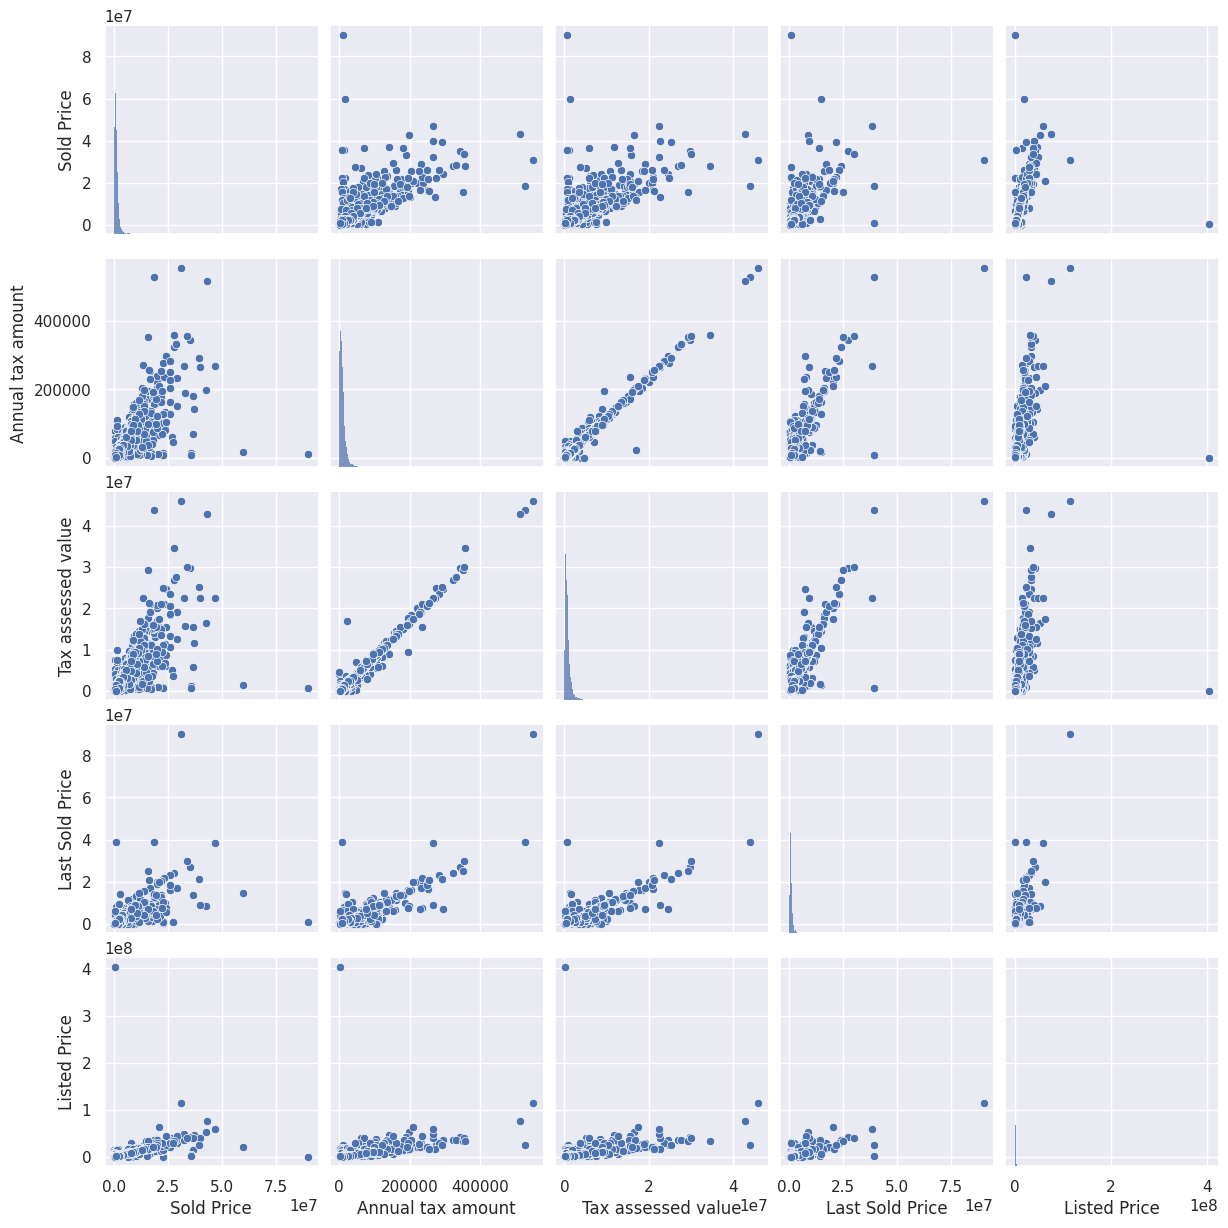

In [8]:
sns.set()
sns.pairplot(train_data[cols])
plt.show()

一般情况下，房价应该和面积成正比关系，但是上面的热力图并没有体现，同样绘制散点图帮助分析。

首先看下分布，**Total interior livable area**和**Total spaces**这两个特征，最小值竟然有1和负数，这些值是不对，而**Lot**虽然有0（类似 missing value），但是整体上更符合实际意义。

In [9]:
area_columns = ['Lot', 'Total interior livable area', 'Total spaces']
for col in area_columns:
    print(train_data[col].describe())
    print()

count    3.325800e+04
mean     2.353383e+05
std      1.192507e+07
min      0.000000e+00
25%      4.991000e+03
50%      6.502000e+03
75%      1.045400e+04
max      1.897474e+09
Name: Lot, dtype: float64

count    4.491300e+04
mean     5.774587e+03
std      8.324363e+05
min      1.000000e+00
25%      1.187000e+03
50%      1.566000e+03
75%      2.142000e+03
max      1.764164e+08
Name: Total interior livable area, dtype: float64

count    46523.000000
mean         1.567117
std          9.011608
min        -15.000000
25%          0.000000
50%          1.000000
75%          2.000000
max       1000.000000
Name: Total spaces, dtype: float64



散点图给我的感觉就是房价和面积毫无关系，其次上面的分析只有 **Lot**更有实际意义，因此可以只保留**Lot**，其他两个特征删除。

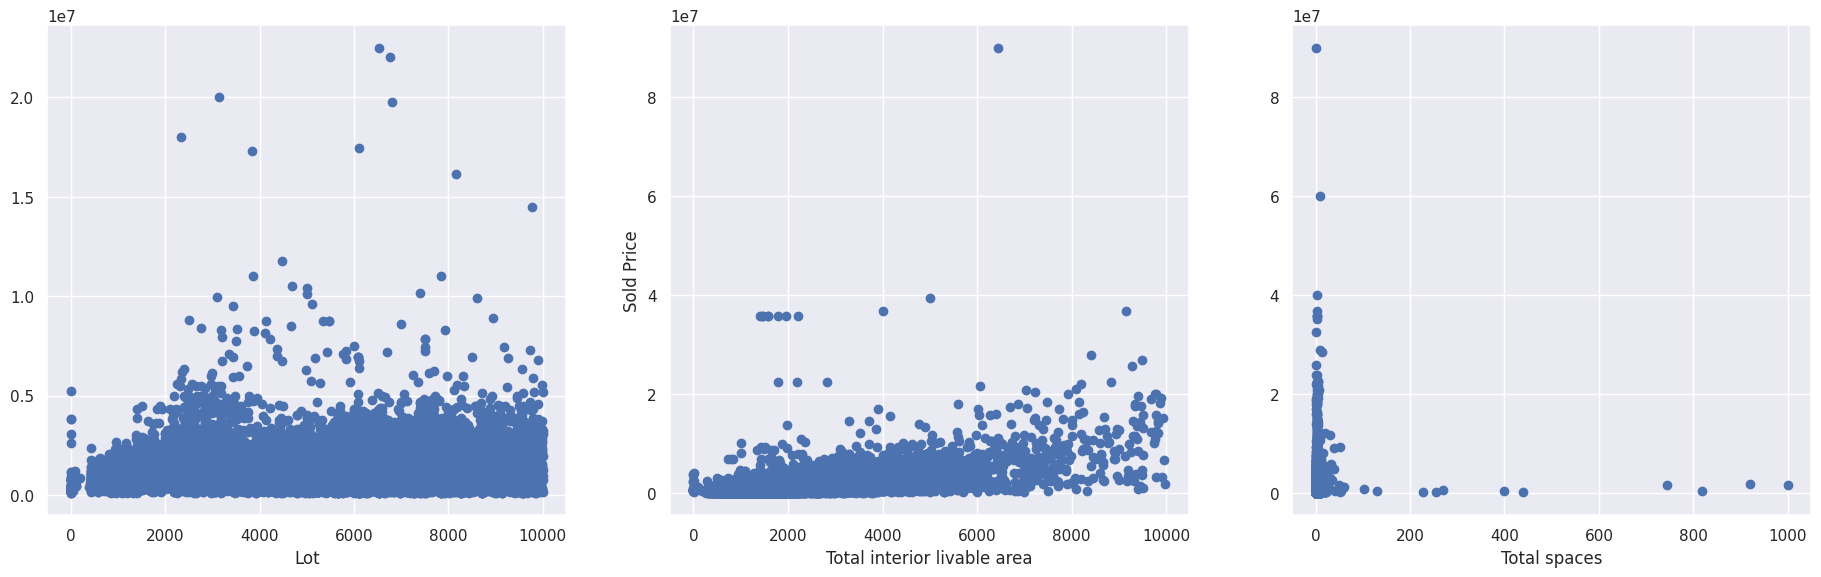

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, feat in enumerate(['Lot', 'Total interior livable area', 'Total spaces']):
    axes[i].set_xlabel(feat), axes[1].set_ylabel('Sold Price')
    data = pd.concat([train_data[feat], train_data['Sold Price']], axis=1)
    data = data.loc[data[feat]>0]
    data = data.loc[data[feat]<10000]
    x = np.array(data[feat].values).reshape(-1, 1)
    y = np.array(data['Sold Price'].values).reshape(-1, 1)
    axes[i].scatter(x, y) 
plt.show()

#### 类别特征

**Year built**应该属于很强烈的特征，毕竟相比较老房子，新房子的价格应该更高

In [11]:
train_data["Year built"].describe()

count    46394.000000
mean      1956.634888
std        145.802456
min          0.000000
25%       1946.000000
50%       1967.000000
75%       1989.000000
max       9999.000000
Name: Year built, dtype: float64

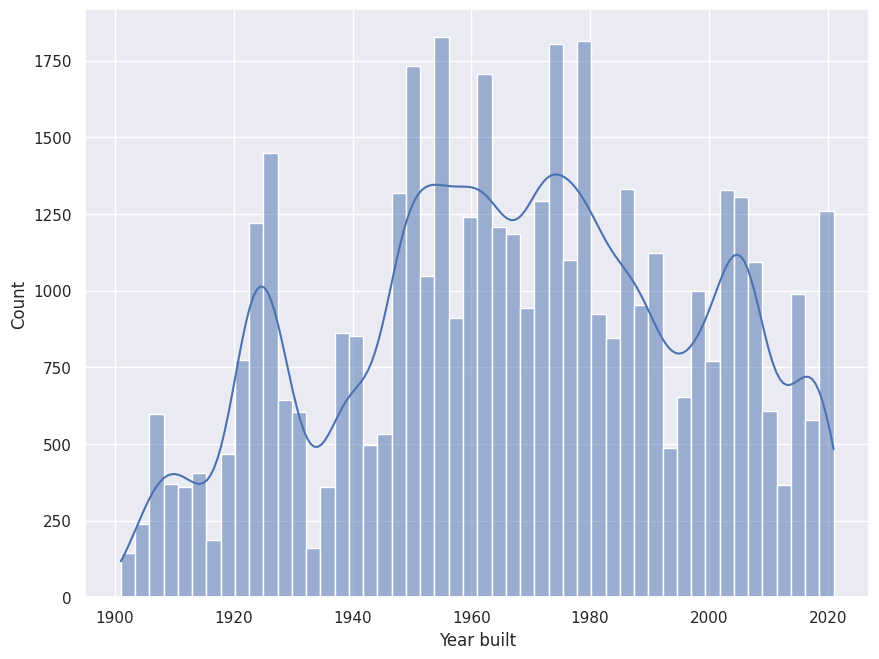

In [12]:
data = train_data["Year built"].loc[train_data["Year built"]>1900].loc[train_data["Year built"]<2023]
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data, ax=ax, kde=True)
plt.show()

从箱线图来看，**Year built**和房价并没有线性关系，也就是房子越新，房价越高。

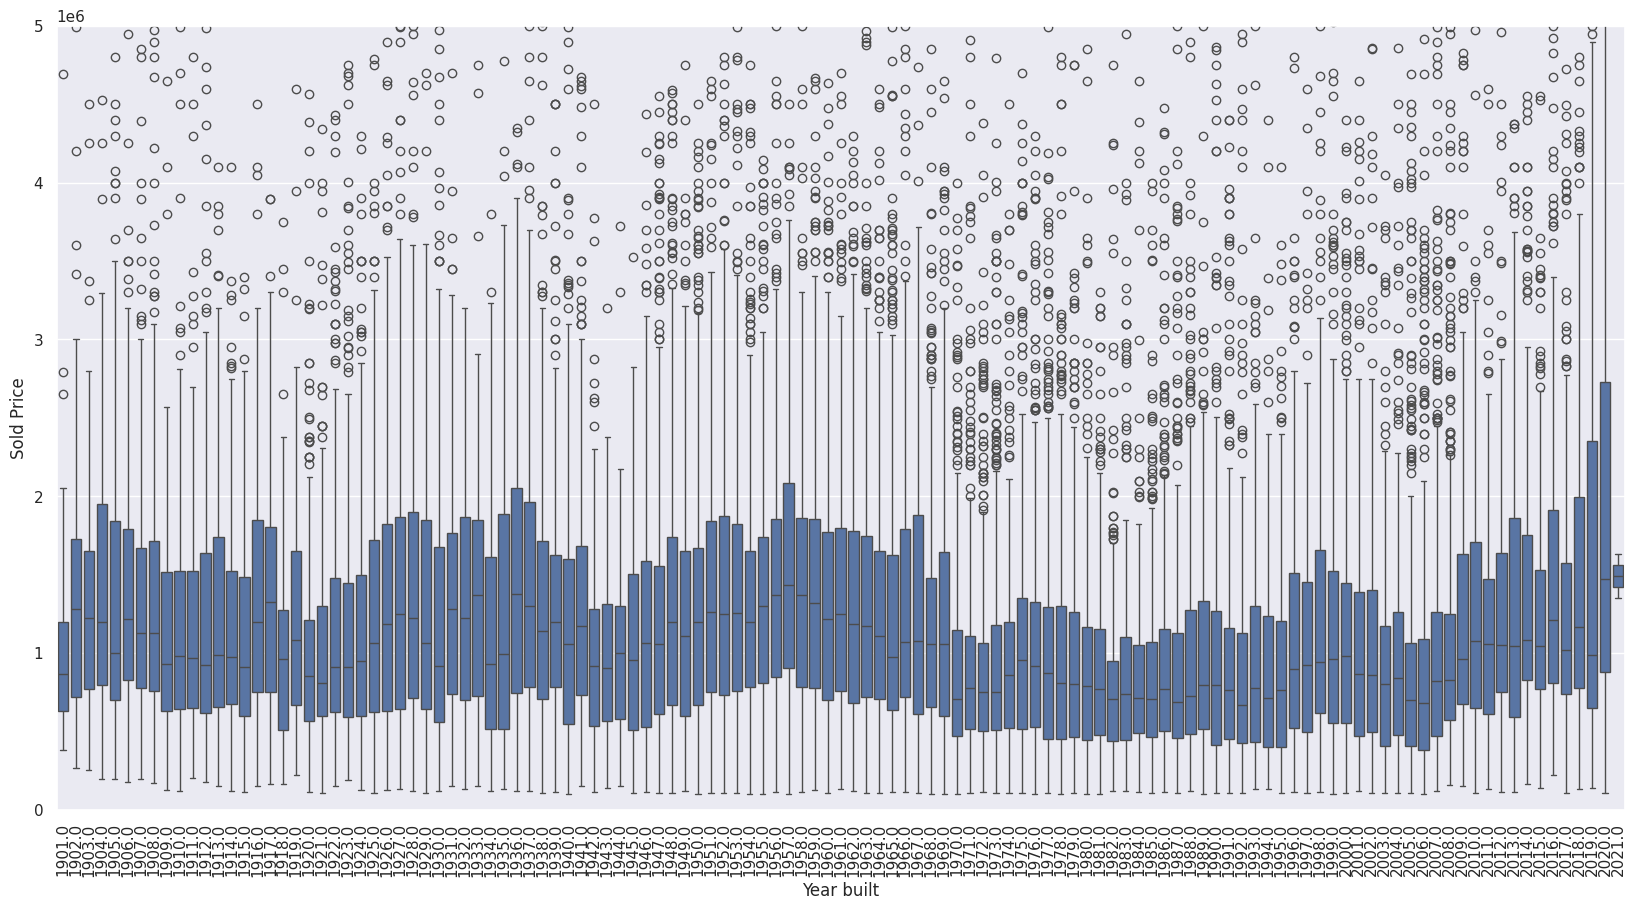

In [13]:
data = pd.concat([train_data["Year built"], train_data["Sold Price"]], axis=1)
data = data.loc[data["Year built"]>1900].loc[data["Year built"]<2023]
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x="Year built", y="Sold Price", data=data, ax=ax)
ax.set_ylim(0, 5000000)
plt.xticks(rotation=90)
plt.show()

再看**Full bathrooms**，很强烈的线性关系。

In [14]:
train_data['Full bathrooms'].describe()

count    39574.000000
mean         2.094961
std          0.963320
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         17.000000
Name: Full bathrooms, dtype: float64

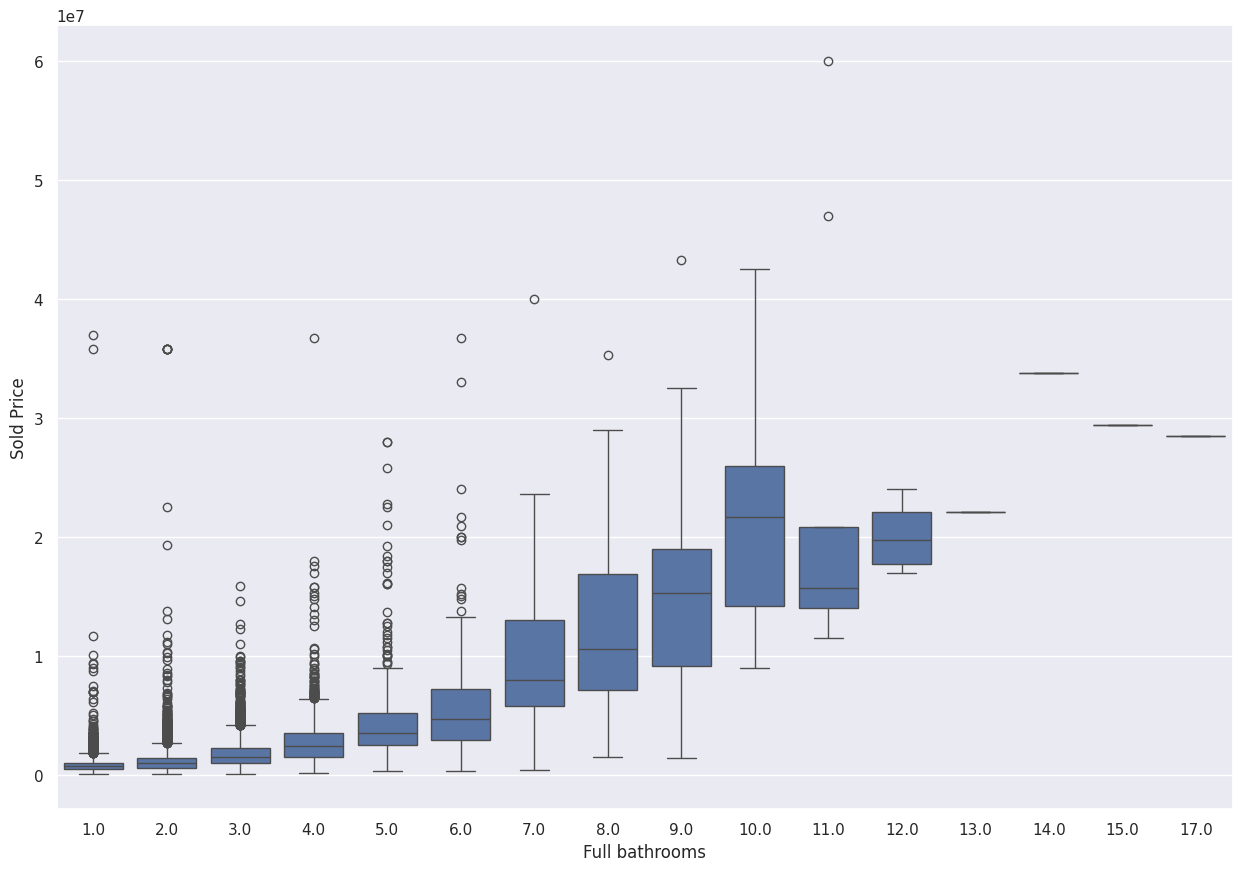

In [15]:
data = pd.concat([train_data["Full bathrooms"], train_data["Sold Price"]], axis=1)
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='Full bathrooms', y='Sold Price', data=data, ax=ax)
plt.show()

**City**应该和房价关系很大，通过抽样30个城市，抽样的规则如下：

按照城市的评价房价划分30个区间，每个区间随机挑选一个城市以及该城市的样本数量大于50个，并绘制箱线图。

从箱线图可以得到如下结论：

- 平均房价越高的城市其房价方差越大

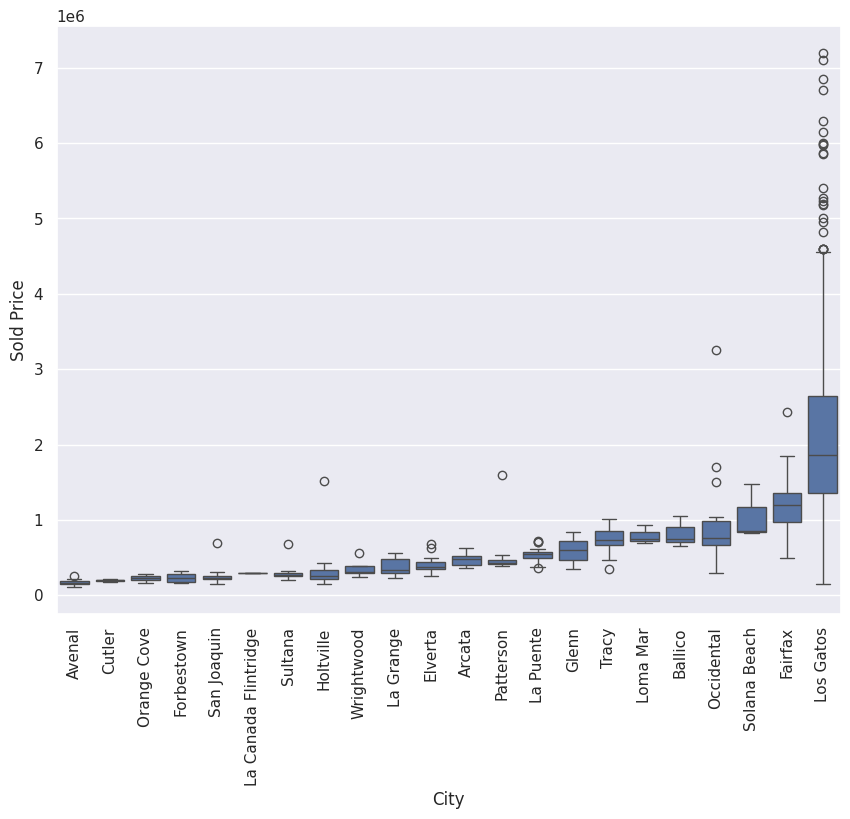

In [16]:
group_by_city = train_data.groupby("City")
data = group_by_city.mean("Sold Price")["Sold Price"]
count = group_by_city["City"].count()
data = data.sort_values()
k = 30
interval_num = len(data) // k
remain_num = len(data) % k
cities = []
start = 0
for i in range(k):
    end = start + k
    if i < remain_num:
        end += 1
    loop_cnt = 0
    while loop_cnt < k:
        idx = np.random.randint(start, end)
        if count[idx] < 50:
            loop_cnt += 1
            continue
        cities.append(data.index[idx])
        break
    start = end
data = pd.concat([train_data["City"], train_data["Sold Price"]], axis=1)
data = data[data["City"].isin(cities)]
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='City', y='Sold Price', data=data, ax=ax, order=cities)
plt.xticks(rotation=90)
plt.show()

另外还有一个**Region**，和**City**高度重合，这两个特征可以只用一个或者对于missing value互相填充。

### 特征预处理

In [17]:
train_data.shape, test_data.shape

((47439, 40), (31626, 39))

#### 异常点(Outliers)

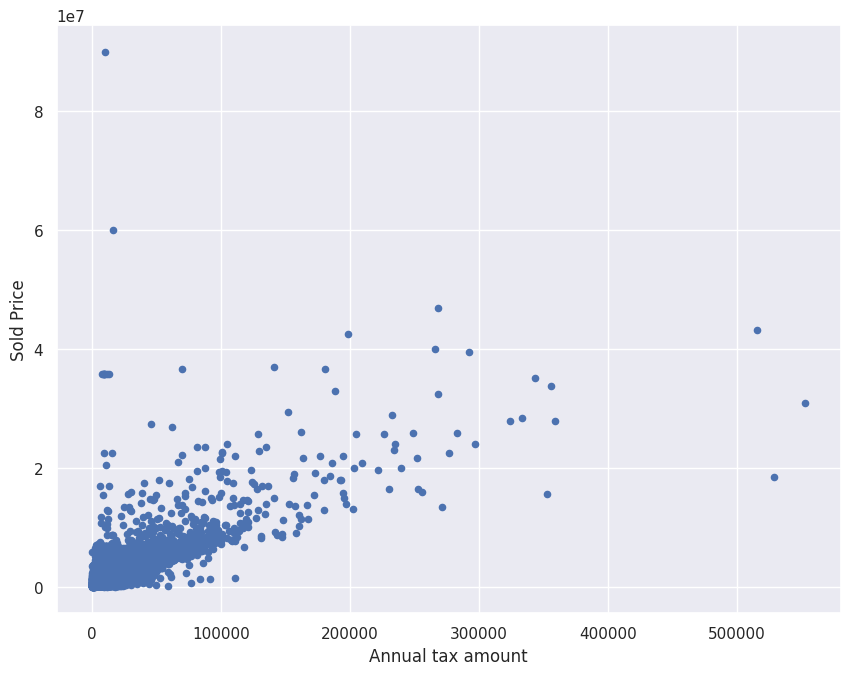

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
data = pd.concat([train_data["Annual tax amount"], train_data["Sold Price"]], axis=1)
data.plot.scatter(x="Annual tax amount", y="Sold Price", ax=ax)
plt.show()

(47438, 40)


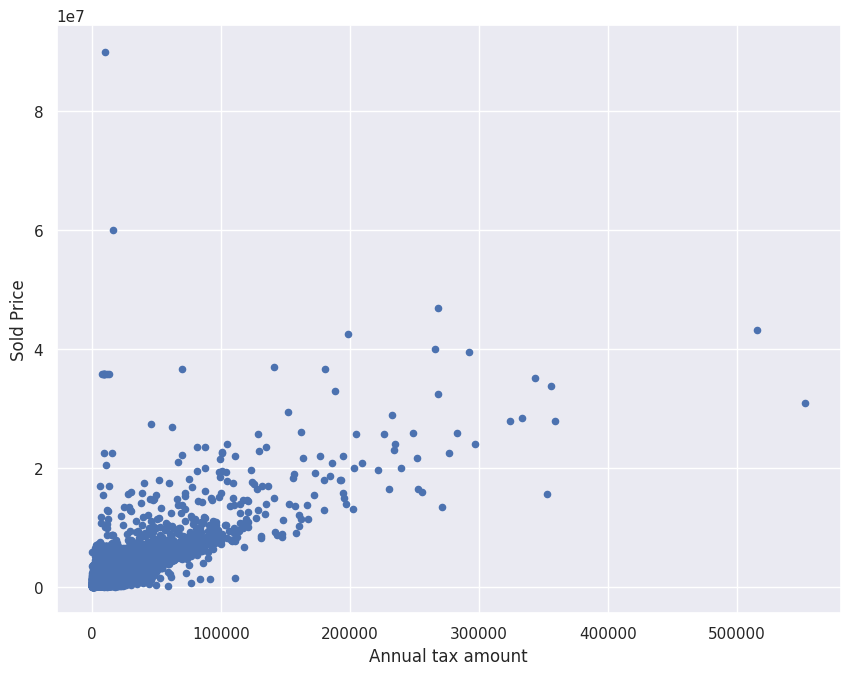

In [19]:
train_data = train_data.drop(
    train_data[(train_data['Annual tax amount']>500000) & (train_data['Sold Price']<2e7)].index)
fig, ax = plt.subplots(figsize=(8, 6))
data = pd.concat([train_data["Annual tax amount"], train_data["Sold Price"]], axis=1)
data.plot.scatter(x="Annual tax amount", y="Sold Price", ax=ax)
print(train_data.shape)
plt.show()

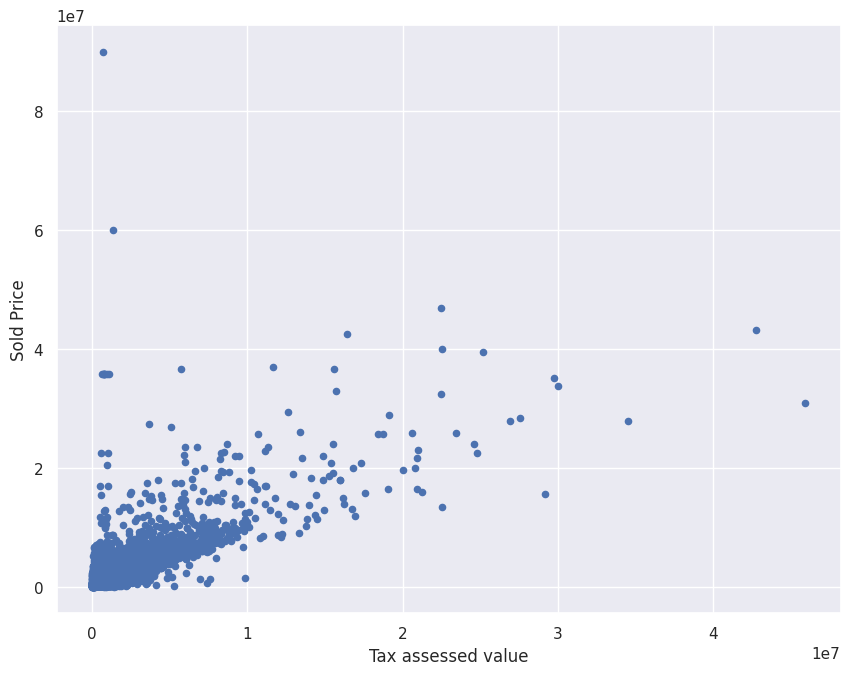

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
data = pd.concat([train_data["Tax assessed value"], train_data["Sold Price"]], axis=1)
data.plot.scatter(x="Tax assessed value", y="Sold Price", ax=ax)
plt.show()

(47436, 40)


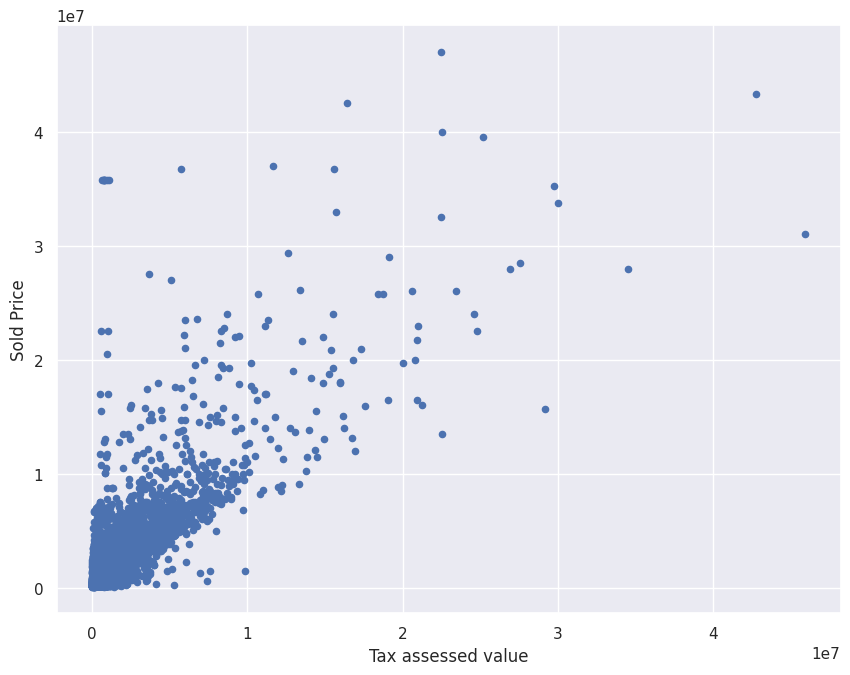

In [21]:
train_data = train_data.drop(
    train_data[(train_data['Tax assessed value']<1e7) & (train_data['Sold Price']>4e7)].index)
fig, ax = plt.subplots(figsize=(8, 6))
data = pd.concat([train_data["Tax assessed value"], train_data["Sold Price"]], axis=1)
data.plot.scatter(x="Tax assessed value", y="Sold Price", ax=ax)
print(train_data.shape)
plt.show()

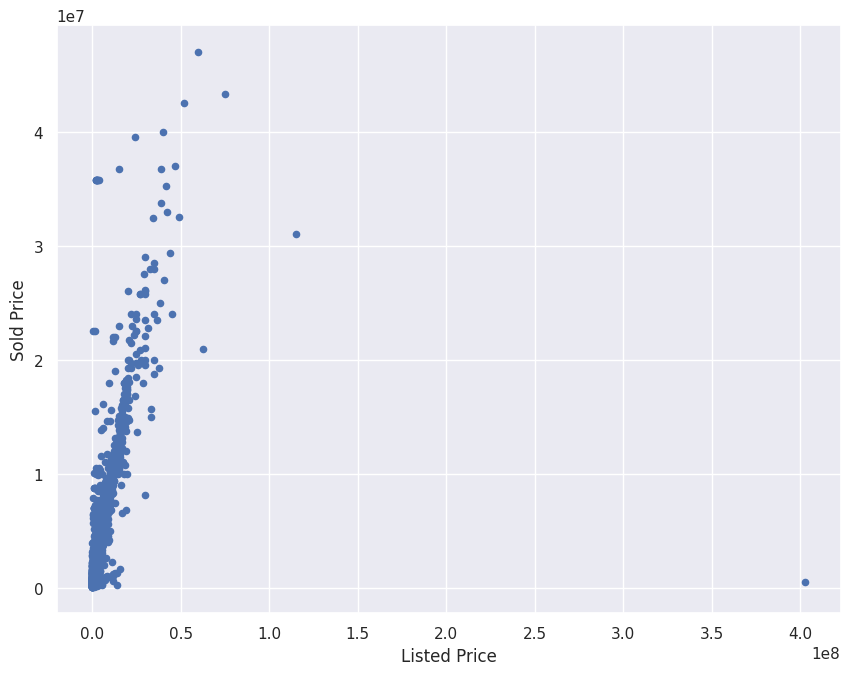

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
data = pd.concat([train_data["Listed Price"], train_data["Sold Price"]], axis=1)
data.plot.scatter(x="Listed Price", y="Sold Price", ax=ax)
plt.show()

(47435, 40)


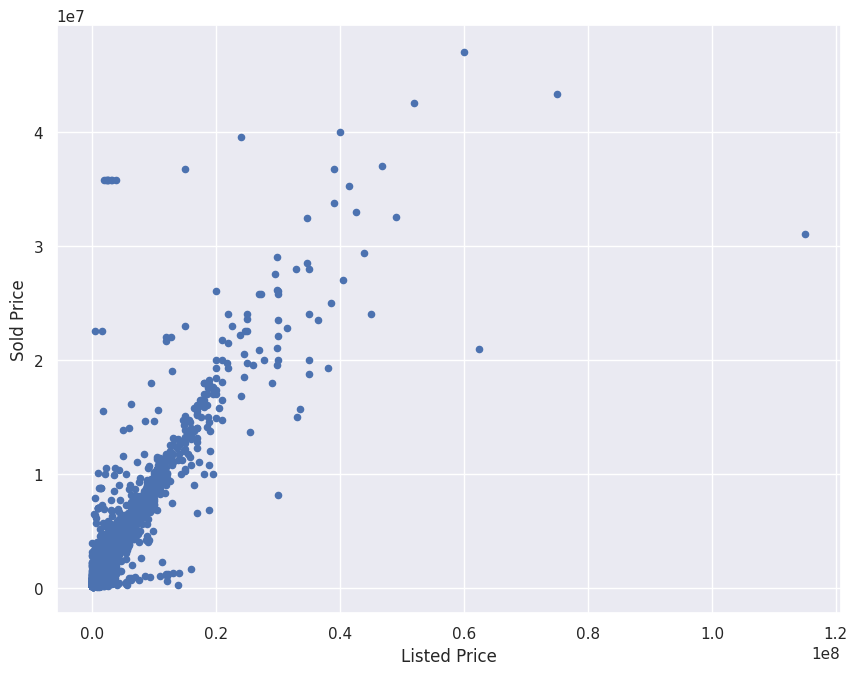

In [23]:
train_data = train_data.drop(
    train_data[(train_data['Listed Price']>4e8) & (train_data['Sold Price']<1e7)].index)
fig, ax = plt.subplots(figsize=(8, 6))
data = pd.concat([train_data["Listed Price"], train_data["Sold Price"]], axis=1)
data.plot.scatter(x="Listed Price", y="Sold Price", ax=ax)
print(train_data.shape)
plt.show()

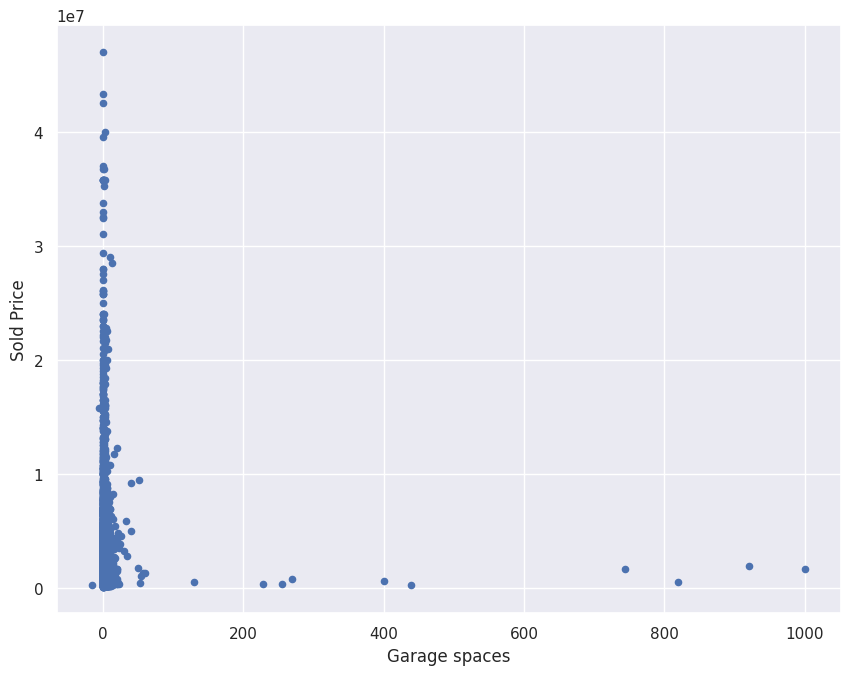

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
data = pd.concat([train_data["Garage spaces"], train_data["Sold Price"]], axis=1)
data.plot.scatter(x="Garage spaces", y="Sold Price", ax=ax)
plt.show()

(47433, 40)


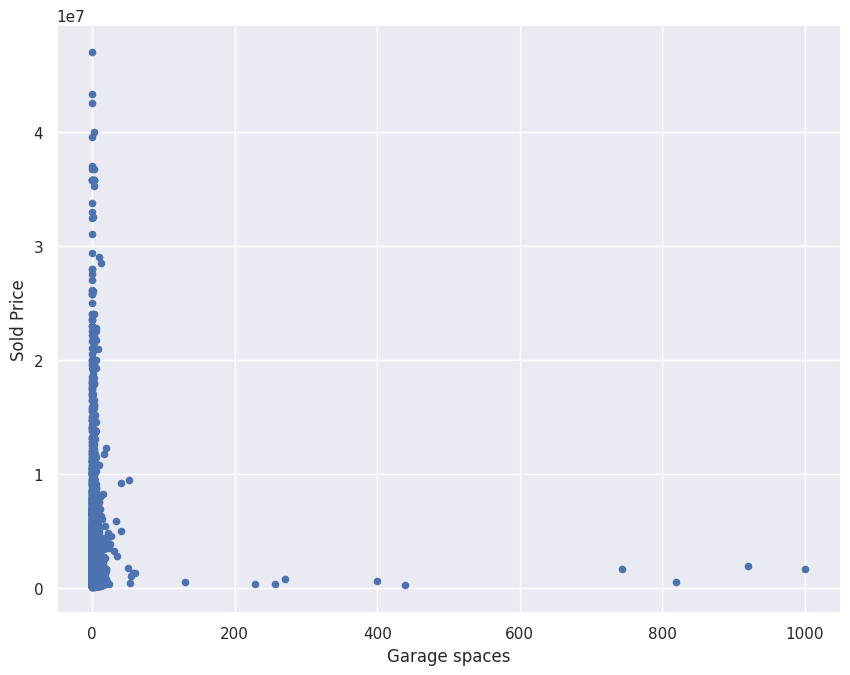

In [25]:
train_data = train_data.drop(
    train_data[train_data['Garage spaces']<0].index)
fig, ax = plt.subplots(figsize=(8, 6))
data = pd.concat([train_data["Garage spaces"], train_data["Sold Price"]], axis=1)
data.plot.scatter(x="Garage spaces", y="Sold Price", ax=ax)
print(train_data.shape)
plt.show()

####  Missing value

In [26]:
all_data = pd.concat([train_data, test_data])
all_data.shape

(79059, 40)

前面的特征分析中，和面积相关的三个特征**Lot**，**Total interior livable area**，**Total spaces**，其中只有**Lot**数据更准确，因此考虑将**Total interior livable area**和**Total spaces**这两个特征给删除。

In [27]:
all_data.drop(["Total interior livable area", "Total spaces"], axis=1, inplace=True)
all_data.shape

(79059, 38)

**Lot**中的missing value使用各个城市**Lot**的中位数来填充，如果样本所在的城市的**Lot**全部为NaN，就是用**Region**，如果还有NaN，就是用所有样本的中位数。

In [28]:
all_data["Lot"] = all_data.groupby("City")["Lot"].transform(lambda x: x.fillna(x.median()))
all_data["Lot"] = all_data.groupby("Region")["Lot"].transform(lambda x: x.fillna(x.median()))
all_data["Lot"] = all_data.groupby("State")["Lot"].transform(lambda x: x.fillna(x.median()))
all_data["Lot"] = all_data["Lot"].transform(lambda x: x.fillna(x.median()))
all_data["Lot"].isna().sum()

0

**Garage spaces**特征的missing value用填充，表示没有车库

In [29]:
all_data["Garage spaces"] = all_data["Garage spaces"].fillna(0)
all_data["Garage spaces"].isna().sum()

0

学区相关的特征，对于没有学区的房子，其对应的**Score**类型特征为0，**Distance**设为最大值的两倍，以保证足够的惩罚。

In [30]:
feat = ["Elementary", "Middle", "High"]
for i in feat:
    school, score, distance = f"{i} School", f"{i} School Score", f"{i} School Distance"
    all_data[school] = all_data[school].fillna('None')
    all_data[score] = all_data[score].fillna(0)
    all_data[distance] = all_data[distance].fillna(all_data[distance].max()*2)
    print(all_data[school].isna().sum(), all_data[score].isna().sum(), all_data[distance].isna().sum(), all_data[distance].max())

0 0 0 114.4
0 0 0 114.4
0 0 0 147.8


**Tax assessed value**和**Annual tax amount**这两个特征前面分析是一组相关度很高的特征，这种相关度很高的特征可以考虑只保留一个，不过是在模型无论怎么调参都无法拟合才去做，这里只考虑如何处理missing value。

对于missing value的规则和**Lot**一样。

In [31]:
for var in ["Tax assessed value", "Annual tax amount"]:
    all_data[var] = all_data.groupby("City")[var].transform(lambda x: x.fillna(x.median()))
    all_data[var] = all_data.groupby("Region")[var].transform(lambda x: x.fillna(x.median()))
    all_data[var] = all_data.groupby("State")[var].transform(lambda x: x.fillna(x.median()))
    all_data[var] = all_data[var].transform(lambda x: x.fillna(x.median()))
    print(all_data[var].isna().sum())

0
0


**Listed Price**和**Last Sold Price**这是两个特征，missing value对于训练数据可设置为**Sold Price**，对于测试数据，和**Lot**一样的规则。

In [32]:
for var in ["Listed Price", "Last Sold Price"]:
    data = pd.concat([train_data[var], train_data["Sold Price"]], axis=1)
    def op(x):
        x[x.isna()] = x.loc["Sold Price"]
        return x
    data = data.transform(op, axis=1)
    all_data[var].iloc[:data.shape[0]] = data[var]
    all_data[var] = all_data.groupby("City")[var].transform(lambda x: x.fillna(x.median()))
    all_data[var] = all_data.groupby("Region")[var].transform(lambda x: x.fillna(x.median()))
    all_data[var] = all_data.groupby("State")[var].transform(lambda x: x.fillna(x.median()))
    all_data[var] = all_data[var].transform(lambda x: x.fillna(x.median()))
    print(all_data[var].isna().sum())

0
0


**Bedrooms**这个特征既包含字符串也包含数字，字符串形容房子中卧室的位置、卧室家具以及数量等信息，可以近似地认为使用逗号分隔的卧室列表。

In [33]:
def op(x):
    try:
        n = int(x)
    except:
        if isinstance(x, str):
            n = len(x.split(','))
        else:
            assert(np.isnan(x))
            n = np.nan
    return n
all_data["Bedrooms"] = all_data["Bedrooms"].transform(op)
var = "Bedrooms"
all_data[var] = all_data[var].fillna(0)
all_data[var].isna().sum()

0

In [34]:
for var in ["Bathrooms", "Full bathrooms"]:
    all_data[var] = all_data[var].fillna(0) 
    print(all_data[var].isna().sum())

0
0


In [35]:
all_data["Year built"] = all_data["Year built"].fillna(0)
all_data["Year built"].isna().sum()

0

In [36]:
for i in all_data[all_data["Region"].isna()].index:
    row = all_data.iloc[i]
    row["Region"] = row["City"]
    all_data.iloc[i] = row
all_data["Region"].isna().sum()

0

In [37]:
all_data["Flooring"] = all_data["Flooring"].fillna(all_data["Flooring"].mode()[0])
all_data["Flooring"].isna().sum()

0

In [38]:
all_data["Last Sold On"] = all_data["Last Sold On"].fillna("1900-01-01")
all_data["Last Sold On"].isna().sum()

0

In [39]:
for var in ["Summary", "Appliances included", "Laundry features", ]:
    all_data[var] = all_data[var].fillna("None")

In [40]:
for i, j in [("Heating", "Heating features",), 
             ("Cooling", "Cooling features",), 
             ("Parking", "Parking features",)]:
    for k in all_data[all_data[i].isna()].index:
        row = all_data.iloc[k]
        row[i] = row[j]
        all_data.iloc[k] = row
    for k in all_data[all_data[j].isna()].index:
        row = all_data.iloc[k]
        row[j] = row[i]
        all_data.iloc[k] = row
    all_data[i] = all_data[i].fillna("None")
    all_data[j] = all_data[j].fillna("None")

In [41]:
all_data.isna().sum().sum()-len(test_data)

0

#### 特征编码

对于只会包含一种类别的特征，直接使用`LabelEncode`编码

In [42]:
cities, regions = all_data["City"].unique().tolist(), all_data["Region"].unique().tolist()
all_cities = list(set(cities).union(set(regions)))
lbl = LabelEncoder()
lbl.fit(all_cities)
all_data["City"] = lbl.transform(list(all_data["City"].values))
all_data["Region"] = lbl.transform(list(all_data["Region"].values))

In [43]:
def op(x):
    if x > 2021:
        x = 2021
    return x
all_data["Year built"] = all_data["Year built"].transform(op)
cols = ("Type", "Year built", "Bedrooms", "Bathrooms", "Full bathrooms", "Elementary School",
        "Elementary School Score", "Middle School", "Middle School Score", "High School", "High School Score",
        "Listed On", "Last Sold On", "Zip", "State")
for col in cols:
    lbl = LabelEncoder()
    lbl.fit(all_data[col].values.tolist())
    all_data[col] = lbl.transform(all_data[col].values.tolist())
all_data.shape

(79059, 38)

**Heating**是一个包含多种类别的特征，使用`LabelEncode`可能不能很好的包含这种多类别的信息。

使用`MultiLabelBinarizer`，这种一种类似独热编码的方式，但是编码不再只包含一个1，而是可能包含多个1。

In [44]:
cols = ["Heating", "Cooling", "Parking", "Flooring", "Heating features", "Cooling features", 
        "Appliances included", "Laundry features", "Parking features", ]
multi_label_data = all_data[cols]
for col in cols:
    all_data.drop(col, axis=1, inplace=True)
all_data.drop("Sold Price", axis=1, inplace=True)
print(all_data.shape)

(79059, 28)


In [45]:
summary_and_address = all_data[["Address", "Summary"]]
all_data.drop(["Address", "Summary"], axis=1, inplace=True)
all_data_columns = all_data.columns.values.tolist()
all_data.shape

(79059, 26)

In [46]:
all_features = torch.tensor(all_data.values, dtype=torch.float32)
all_features.shape 

torch.Size([79059, 26])

In [47]:
for col in cols:
    feat = []
    for i in multi_label_data[col]:
        feat.append([j.strip() for j in i.split(',')])
    mlb = MultiLabelBinarizer()
    mlb.fit(feat)
    t_feat = mlb.transform(multi_label_data[col].values.tolist())
    all_features = torch.cat((all_features, torch.tensor(t_feat, dtype=torch.float32)), axis=1)
all_features.shape

torch.Size([79059, 1218])

**Address**的格式如下

地址是独一无二的，不论是何种编码方式，都难以覆盖所有场景。

> [门牌号] 街道 [单元号]

如果能直接拿到街道名，然后街道名使用`LabelEncoder`编码就非常nice了。


In [48]:
def get_street(addr: str) -> str:
    addr_sp = addr.split(' ')
    while addr_sp[0].isnumeric() or not addr_sp[0].isalnum():
        addr_sp = addr_sp[1:]
        if not addr_sp:
            break 
    if not addr_sp:
        return ""
    if  addr_sp[-1].isnumeric():
        addr_sp = addr_sp[:-2]
    if addr_sp and addr_sp[-1].startswith('#'):
        addr_sp = addr_sp[:-1]
    addr_sp = [s.lower() for s in addr_sp]
    for i in ["unit", "rm", "apt", "room", "apartment", "department", "bsmt",
              "fl", "floor", "front", "frnt", "garage", "grge", "lot", "office",
              "ofc", "ph", "penthouse", "pier", "trailer", "trlr", "slip",
              "lobby", "lbby", "ste", "suite", "stop", "dept", "space", "spc"]:
        try:
            j = addr_sp.index(i)
        except:
            continue
        addr_sp = addr_sp[:j]
        break
    return ' '.join(addr_sp)

unique_val = []
for addr in summary_and_address["Address"]:
    s = get_street(addr)
    unique_val.append(s)
lbl = LabelEncoder()
lbl.fit(list(set(unique_val)))
t_feat = lbl.fit_transform(unique_val)
t_feat = t_feat.reshape(-1, 1)
all_features = torch.cat((all_features, torch.tensor(t_feat, dtype=torch.float32)), axis=1)
all_features.shape

torch.Size([79059, 1219])

现在还差最难的一个特征**Summary**没有编码，**Summary**是对房子的简介，包含较多单词，并且是不定长的序列，比较难处理。

暂时先把不考虑该特征来训练试试。

#### normalize feature

In [49]:
def get_feature_index(feat):
    for i, f in enumerate(all_data_columns):
        if f == feat:
            return i
    assert(False)

首先看下**Sold Price**

In [50]:
train_data['Sold Price'].describe()

count    4.743300e+04
mean     1.292316e+06
std      1.619349e+06
min      1.005000e+05
25%      5.650000e+05
50%      9.590000e+05
75%      1.525000e+06
max      4.700000e+07
Name: Sold Price, dtype: float64

**Sold Price**并不是正态分布。

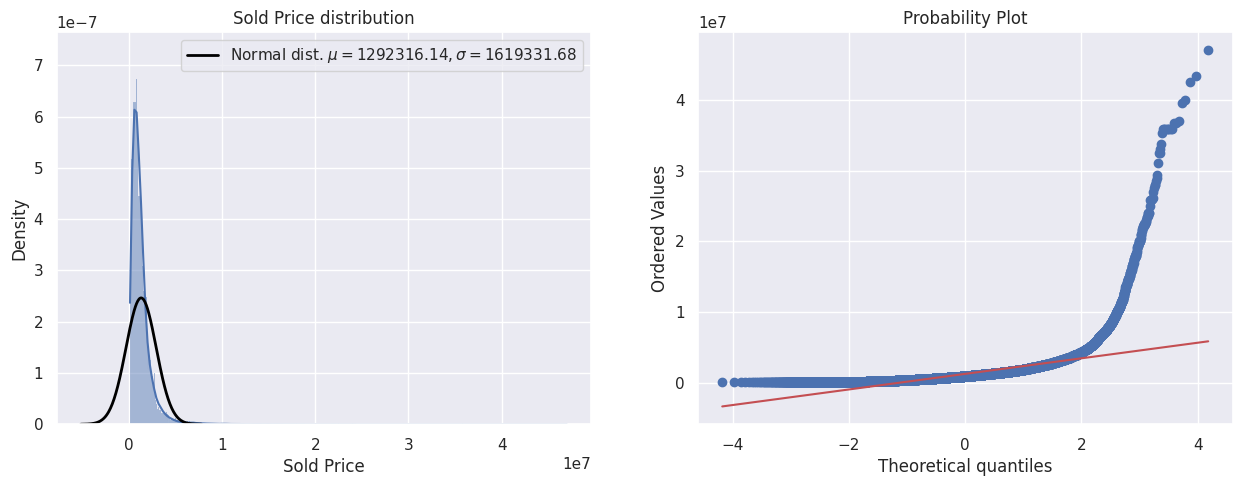

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(train_data['Sold Price'], kde=True, stat='density', ax=axes[0])
mu, sigma = norm.fit(train_data['Sold Price'])
label = "Normal dist. $\mu={:.2f}, \sigma={:.2f}$".format(mu, sigma)
normal(train_data['Sold Price'].mean(), train_data['Sold Price'].std(), label=label, ax=axes[0])
axes[0].set_title('Sold Price distribution')
axes[0].legend()
stats.probplot(train_data['Sold Price'], plot=axes[1])
plt.show()

使用log变换，看起来比较符合正态分布了。

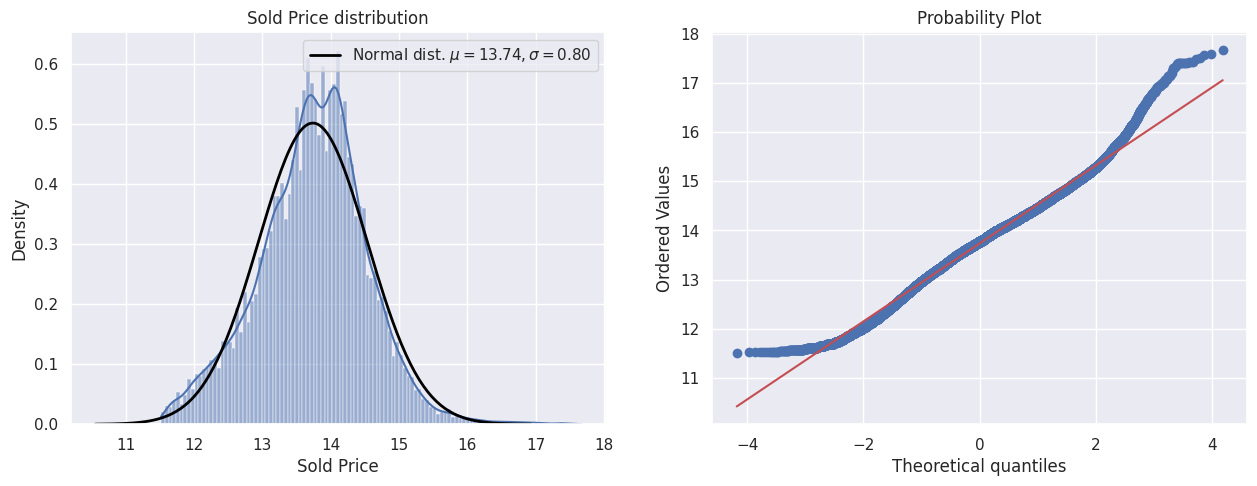

In [52]:
train_data['Sold Price'] = np.log(train_data['Sold Price'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(train_data['Sold Price'], kde=True, stat='density', ax=axes[0])
mu, sigma = norm.fit(train_data['Sold Price'])
label = "Normal dist. $\mu={:.2f}, \sigma={:.2f}$".format(mu, sigma)
normal(train_data['Sold Price'].mean(), train_data['Sold Price'].std(), label=label, ax=axes[0])
axes[0].set_title('Sold Price distribution')
axes[0].legend()
stats.probplot(train_data['Sold Price'], plot=axes[1])
plt.show()

In [53]:
train_labels = torch.tensor(train_data["Sold Price"].values, dtype=torch.float32)
n_train = train_labels.shape[0]
n_test = test_data.shape[0]
assert(n_train+n_test==all_features.shape[0])

对于具有高偏度的数值类型特征，需要进行转换。

In [54]:
numeric_features = ["Lot", "Garage spaces", "Elementary School Distance", "Middle School Distance",
                    "High School Distance", "Tax assessed value", "Annual tax amount", 
                    "Listed Price", "Last Sold Price", "Bedrooms", 
                    "Bathrooms", "Full bathrooms"]
skewed_features = all_data[numeric_features].skew()
skewed_features = skewed_features[abs(skewed_features) > 0.75]
lam = 0.15
for k in skewed_features.index:
    idx = get_feature_index(k)
    norm_way = None
    if all_data[k].min() >= 0:
        x = np.log1p(all_features[:, idx])
        norm_way = "log1p"
    else:
        x = boxcox1p(all_features[:, idx], lam)
        norm_way = "boxcox1p"
    all_features[:, idx] = x
    skewness = skew(all_features[:, idx])
    print(f"{k}, {norm_way}, old skwness: {skewed_features[k]}, new skwness: {skewness}")

Lot, log1p, old skwness: 102.90807836338193, new skwness: -0.8209776213679068
Garage spaces, log1p, old skwness: 170.01800828515638, new skwness: 0.06149536602358771
Elementary School Distance, log1p, old skwness: 2.5205851535497126, new skwness: 2.0977268887108993
High School Distance, log1p, old skwness: 2.8225423888735057, new skwness: 2.051149408377201
Tax assessed value, log1p, old skwness: 11.897422117579593, new skwness: -0.6309179085195225
Annual tax amount, log1p, old skwness: 17.12949909897998, new skwness: -0.3323474029140133
Listed Price, log1p, old skwness: 15.746249143482459, new skwness: -4.3164691513140205
Last Sold Price, log1p, old skwness: 16.32176243698135, new skwness: -0.842692118355956
Bedrooms, log1p, old skwness: 1.3020988407848941, new skwness: -1.2849655815837453
Bathrooms, log1p, old skwness: 1.5621175154939155, new skwness: -0.8742818330538776
Full bathrooms, log1p, old skwness: 0.827993907603655, new skwness: -0.7327597578453647


## 训练

- 定义多层感知机模型

In [2]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_layers=None, 
                 dropouts=None, active_func=nn.ReLU()):
        if dropouts and len(dropouts) != len(hidden_layers):
            raise ValueError("length of dropouts not equal to number of hidden layer")
        super().__init__()
        print(f"init net: {num_inputs}, {num_outputs}, {hidden_layers}")
        self.active_func = active_func
        self.hidden_layer_modules = []
        self.dropout_modules = []
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        if hidden_layers:
            for i in hidden_layers:
                self.hidden_layer_modules.append(nn.Linear(num_inputs, i))
                num_inputs = i
        if dropouts:
            for p in dropouts:
                self.dropout_modules.append(nn.Dropout(p))

        self.output_layer = nn.Linear(num_inputs, num_outputs)

    def forward(self, X):
        h = X.reshape((-1, self.num_inputs))
        for i, module in enumerate(self.hidden_layer_modules):
            h = module(h)
            if self.dropout_modules and self.training:
                h = self.dropout_modules[i](h)
            self.active_func(h)
        out = self.output_layer(h)
        return out

- 使用K-折交叉验证寻找超参数和训练

In [3]:
def save_model(net, name, train_loss, valid_loss):
    train_loss, valid_loss = torch.tensor(train_loss, dtype=torch.float32), torch.tensor(valid_loss, dtype=torch.float32)
    if os.path.exists(f"{DATA_PATH}/{name}"):
        raise ValueError(f"{DATA_PATH}{name} has exised")
    os.makedirs(f"{DATA_PATH}/{name}")
    with open(f"{DATA_PATH}/{name}/model.bin", "wb+") as f:
        torch.save(net, f)
    with open(f"{DATA_PATH}/{name}/train_loss.bin", "wb+") as f:
        torch.save(train_loss, f)
    with open(f"{DATA_PATH}/{name}/valid_loss.bin", "wb+") as f:
        torch.save(valid_loss, f)

def load_model(name):
    with open(f"{DATA_PATH}/{name}/model.bin", "rb") as f:
        net = torch.load(f)
    with open(f"{DATA_PATH}/{name}/train_loss.bin", "rb") as f:
        train_loss = torch.load(f)
    with open(f"{DATA_PATH}/{name}/valid_loss.bin", "rb") as f:
        valid_loss = torch.load(f)
    return net, train_loss, valid_loss

In [4]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size, loss, 
          need_plot=True, animator=None):
    if isinstance(net, nn.Module):
        net.train()
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    if need_plot:
        if not animator:
            legend = ["train loss"]
            if test_labels != None:
                legend.append("valid loss")
            animator = d2l.Animator(xlabel="epoch", ylabel="loss", 
                                    xlim=[1, num_epochs+1], yscale="log", 
                                    legend=legend, figsize=(6, 4))
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        with torch.no_grad():
            l = loss(net(train_features), train_labels)
            train_ls.append(l)
        loss_l = [l]
        if test_labels is not None:
            with torch.no_grad():
                test_l = loss(net(test_features), test_labels)
                test_ls.append(test_l)
            loss_l.append(test_l)
        if need_plot:
            animator.add(1+epoch, loss_l)
        if (epoch + 1) % 100 == 0:
            name = f"model_{epoch+1}"
            save_model(net, name, train_ls, test_ls)
    return train_ls, test_ls

def k_fold_train(get_net, X_train, y_train,
          num_epochs, learning_rate, weight_decay, batch_size, loss, k=5):
    kf = KFold(k, shuffle=True)
    ncols = 3
    nrows = (k + ncols) // ncols 
    fig = plt.figure(layout="constrained", figsize=(4*ncols, 4*nrows))
    gs = GridSpec(nrows, ncols, fig)
    i, j = 0, 0 
    train_loss_sum, valid_loss_sum = 0, 0
    for t, (train_index, valid_index) in enumerate(kf.split(X_train)):
        train_features, valid_features = X_train[train_index], X_train[valid_index]
        train_labels, valid_labels = y_train[train_index], y_train[valid_index]
        ax = fig.add_subplot(gs[i, j])
        j += 1
        if j == ncols:
            i += 1
            j = 0
        ax.set_xlim(1, num_epochs)
        ax.set_xlabel("epoch"), ax.set_ylabel("rmse loss")
        ax.set_title(r"k={}".format(t+1))
        train_loss, valid_loss = train(get_net(), train_features, train_labels, valid_features, valid_labels,
                                       num_epochs, learning_rate, weight_decay, batch_size, loss,
                                       need_plot=False)
        train_loss_sum += train_loss[-1]
        valid_loss_sum += valid_loss[-1]
        for label, curr_loss, fmt in zip(("train", "valid"), (train_loss, valid_loss), ('k-', 'r--')):
            ax.plot(list(range(1, num_epochs+1)), curr_loss, label=label, linewidth=2)
        ax.legend() 
        if t == 0:
            display.display(fig)
            display.clear_output(wait=True)
    return train_loss_sum / k, valid_loss_sum / k

- 数据集

In [57]:
train_features, test_features = all_features[:n_train], all_features[n_train:]
train_labels = train_labels
assert test_features.shape[0] == n_test and train_labels.shape[0] == train_features.shape[0]
num_inputs, num_outputs = train_features.shape[-1], 1

- 超参数

In [17]:
hidden_layers = []
droupouts = []
num_epochs = 2000
weight_decay = 0
learning_rate = 1e-4
batch_size=4096
loss = nn.MSELoss()
k = 5
model1 = Net(num_inputs, num_outputs)

In [ ]:
# def load():
#     train_features, test_features, train_labels = None, None, None
#     with open(f"{DATA_PATH}/train.bin", "rb") as f:
#         train_features = torch.load(f)
#     with open(f"{DATA_PATH}/test.bin", mode="rb") as f:
#         test_features = torch.load(f)
#     with open(f"{DATA_PATH}/label.bin", "rb") as f:
#         train_labels = torch.load(f)
#     return train_features, test_features, train_labels

# sns.set()

# train_features, test_features, train_labels = load()
# num_inputs, num_outputs = train_features.shape[-1], 1
# assert train_features.dtype == torch.float32 and test_features.dtype == torch.float32 and train_labels.dtype == torch.float32, \
#     f"{train_features.dtype} {test_features.dtype}, {train_labels.dtype}"
# print("load successful:", train_features.shape, train_labels.shape, test_features.shape)
# model1 = torch.load(f"{DATA_PATH}/model.bin")

In [9]:
train_x, valid_x, train_y, valid_y = train_test_split(train_features, train_labels, test_size=0.2)
test_x = test_features

train_x.shape, valid_x.shape

(torch.Size([37946, 1219]), torch.Size([9487, 1219]))

|模型|训练损失|验证损失|超参数|
|:-:|:-:|:-:|:-|
|线性回归</br>model1|0.67|0.66|num_epochs=1000</br>weight_decay=0</br>learning_rate=1e-4</br>batch_size=2048|
|多层感知机</br>model2</br>效果更差||-||

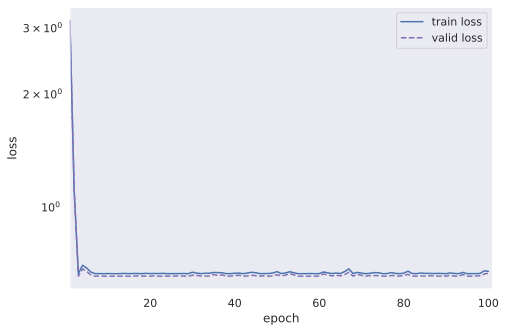

In [18]:
model1_train_loss, model1_valid_loss = train(model1, train_x, train_y, valid_x, valid_y, num_epochs, learning_rate, 
                       weight_decay, batch_size, loss, need_plot=True)

## 预测

In [34]:
model1.eval()
test_pred = model1(test_features).detach().numpy()
test_pred = np.exp(test_pred)
test_pred_df = pd.DataFrame(test_pred, columns=["SalePrice"])
test_data = pd.read_csv("./data/test.csv")
test_pred_df = pd.concat([test_data["Id"], test_pred_df["SalePrice"]], axis=1)
test_pred_df.to_csv("./data/submission.csv", index=False)